<a href="https://colab.research.google.com/github/KAFE45/Colab-LabBCI/blob/main/EEGTest01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving sub-baseline_ses-test01_task-Default_run-001_eeg.xdf to sub-baseline_ses-test01_task-Default_run-001_eeg (1).xdf


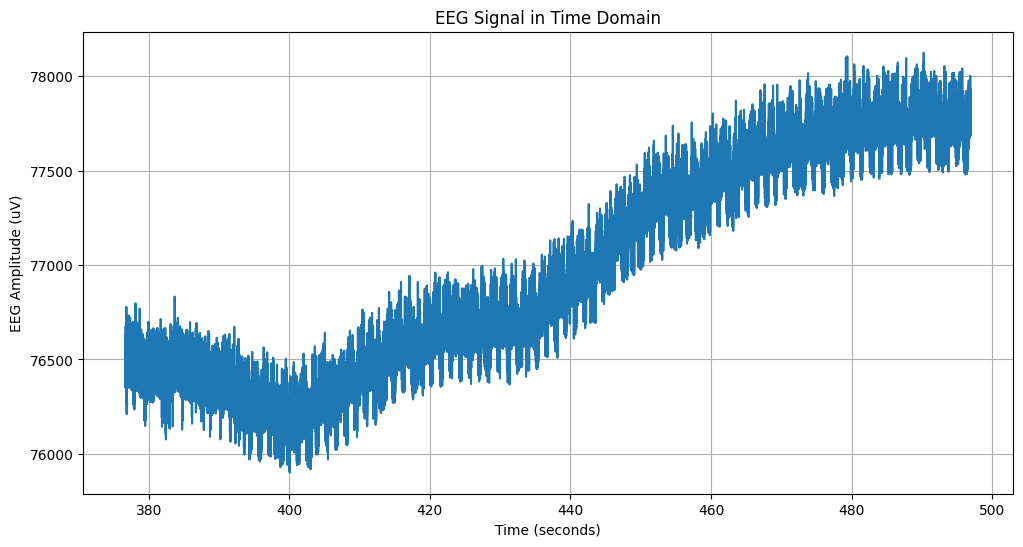

In [ ]:
# ขั้นตอนที่ 1: ติดตั้งไลบรารีที่จำเป็น
!pip install pyxdf matplotlib

# ขั้นตอนที่ 2: อัปโหลดไฟล์ XDF
from google.colab import files
uploaded = files.upload()

# ขั้นตอนที่ 3: อ่านข้อมูลจากไฟล์ XDF
import pyxdf
import numpy as np
import matplotlib.pyplot as plt

# โหลดไฟล์ XDF (สมมติว่าไฟล์ชื่อ 'example.xdf')
xdf_file = list(uploaded.keys())[0]

# อ่านไฟล์ XDF
streams, header = pyxdf.load_xdf(xdf_file)

# ขั้นตอนที่ 4: เลือกสตรีมสัญญาณ EEG (สมมติว่าเป็นสตรีมแรก)
eeg_stream = streams[0]  # เลือกสตรีมที่บันทึกสัญญาณ EEG
eeg_data = eeg_stream['time_series']  # ข้อมูลสัญญาณ EEG
timestamps = eeg_stream['time_stamps']  # เวลาที่แต่ละข้อมูลถูกบันทึก
sample_rate = float(eeg_stream['info']['nominal_srate'][0])  # อัตราการสุ่มตัวอย่าง

# ขั้นตอนที่ 5: เลือกช่องสัญญาณ EEG ที่ต้องการ (สมมติว่าเป็นช่องแรก)
eeg_channel = eeg_data[:, 0]  # เลือกข้อมูลช่องแรกของ EEG

# ขั้นตอนที่ 6: แสดงผลกราฟเวลา (Time Domain) ของสัญญาณ EEG
plt.figure(figsize=(12, 6))
plt.plot(timestamps, eeg_channel)
plt.title('EEG Signal in Time Domain')
plt.xlabel('Time (seconds)')
plt.ylabel('EEG Amplitude (uV)')
plt.grid(True)
plt.show()


In [ ]:
!pip install  mne
!pip install  numpy

import os
import numpy as np
import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw = raw.pick_types(meg=False, eeg=True, eog=False, exclude='bads')

print(raw.info)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 42.4 MB/s eta 0:00:00
Using default location ~/mne_data for sample...
Creating /root/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 1.18TB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 06m28s (1576.2 MB)
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
<Info | 13 non-empty values
 bads: []
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 59 EEG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 59
 projs: Average EEG reference: off
 sfreq: 1

Using matplotlib as 2D backend.


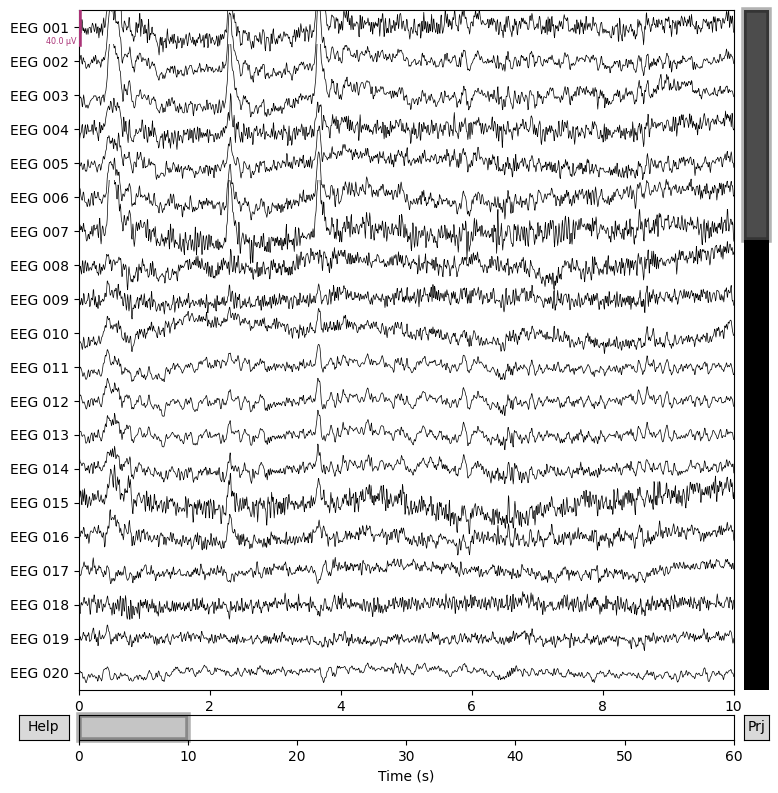

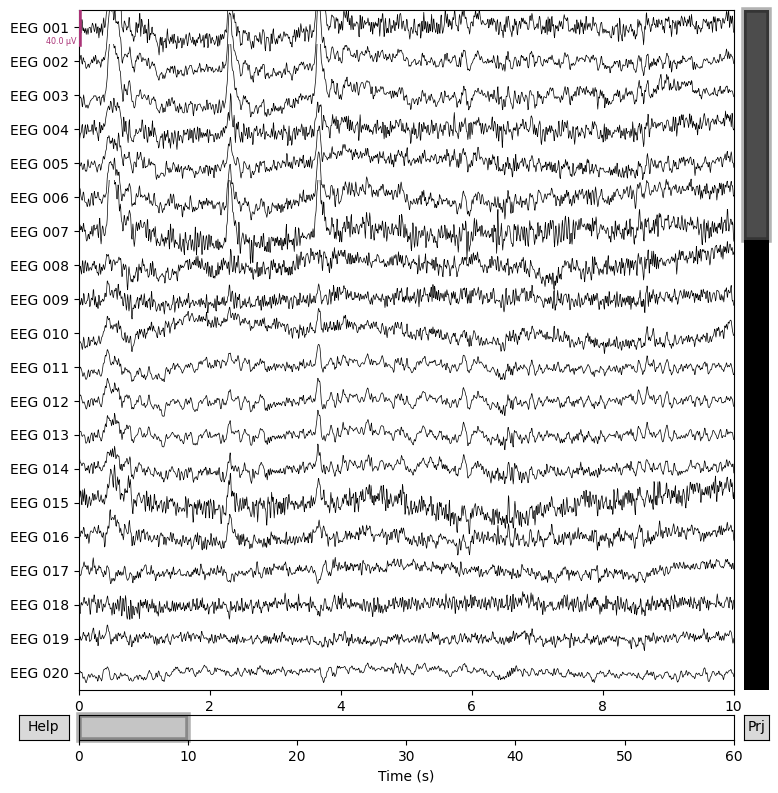

In [ ]:
raw.crop(0, 60) # keeps the first minute of data and discards the rest
raw.plot()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).


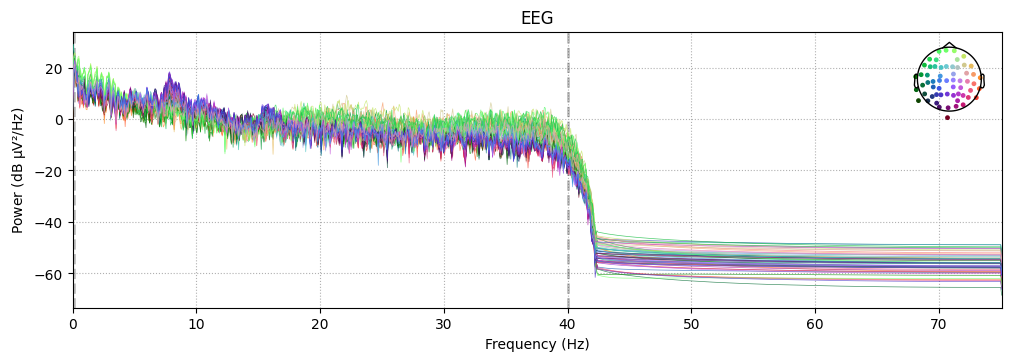

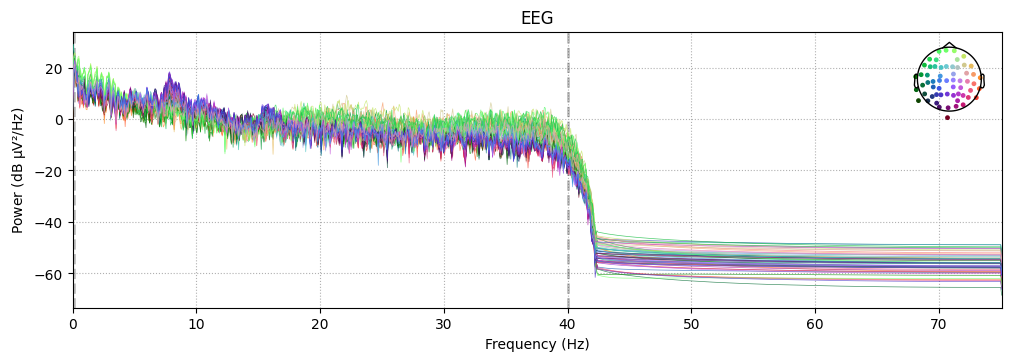

In [ ]:
raw.plot_psd()

## เริ่ม Passt **ทดลอง** Data:

In [ ]:
!pip install pyxdf
!pip install mne
!pip install numpy

In [ ]:
import os
import numpy as np
import mne
import pyxdf

# โหลดไฟล์ XDF
xdf_file = '/content/sub-testEEG_ses-testeegonly_task-Default_run-001_eeg.xdf'
streams, header = pyxdf.load_xdf(xdf_file)

# ตรวจสอบ streams ในไฟล์ XDF
for stream in streams:
    print(f"Stream Name: {stream['info']['name'][0]}")
    print(f"Stream Type: {stream['info']['type'][0]}")
    print(f"Stream Shape: {stream['time_series'].shape}")
    print()

# หา stream ที่เป็น EEG
eeg_stream = None
for stream in streams:
    if 'EEG' in stream['info']['type'][0]:
        eeg_stream = stream
        break

if eeg_stream is None:
    print("ไม่พบข้อมูล EEG ในไฟล์ XDF")
else:
    # แปลงข้อมูล EEG เป็น array
    eeg_data = np.array(eeg_stream['time_series']).T  # ทำการ transpose เนื่องจากข้อมูลใน XDF จะมีรูปแบบ (samples, channels)

    # สร้างข้อมูลในรูปแบบ RawArray เพื่อใช้กับ MNE
    info = mne.create_info(ch_names=[f"EEG{i}" for i in range(eeg_data.shape[0])], sfreq=float(eeg_stream['info']['nominal_srate'][0]), ch_types='eeg')
    raw = mne.io.RawArray(eeg_data, info)

    # แสดงข้อมูลของ raw
    print(raw.info)


Stream Name: eeg
Stream Type: signal
Stream Shape: (30792, 24)

ไม่พบข้อมูล EEG ในไฟล์ XDF


Saving sub-testttt_ses-gfdgfdgdfgfdgfdgfdg_task-Default_run-001_eeg.xdf to sub-testttt_ses-gfdgfdgdfgfdgfdgfdg_task-Default_run-001_eeg (1).xdf
Stream Name: openvibeMarkers
Stream Type: Markers
Stream Shape: (1, 0)

Stream Name: openvibeSignal
Stream Type: signal
Stream Shape: (42800, 24)

Stream Name: eeg
Stream Type: signal
Stream Shape: (42748, 24)

Stream Name: openvibeMarkers
Stream Type: Markers
Stream Shape: (1, 0)

Stream Name: PsychoPyMarkers
Stream Type: Markers
Stream Shape: (1, 0)

ไม่พบข้อมูล EEG ในไฟล์ XDF


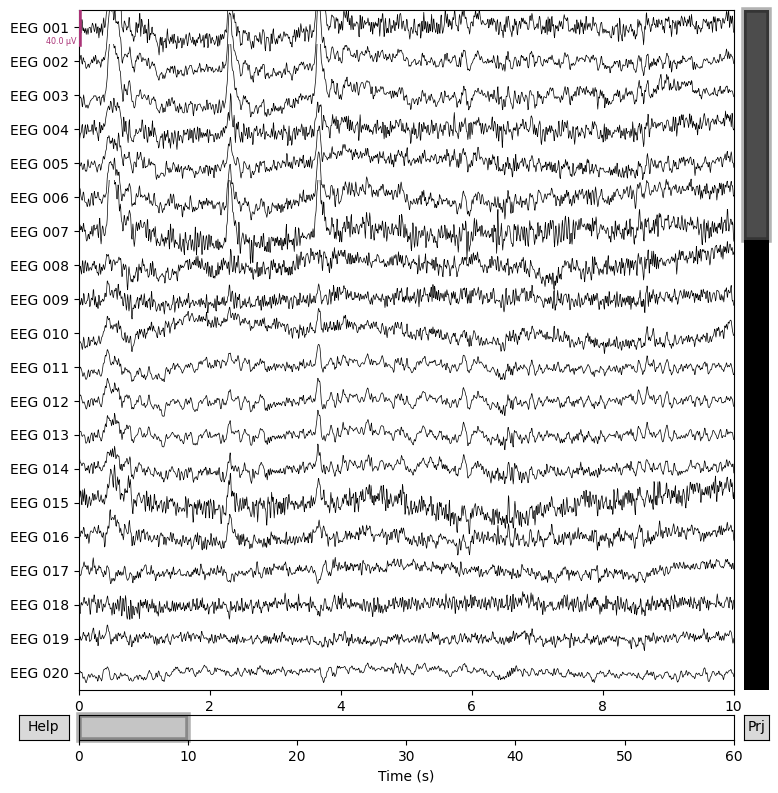

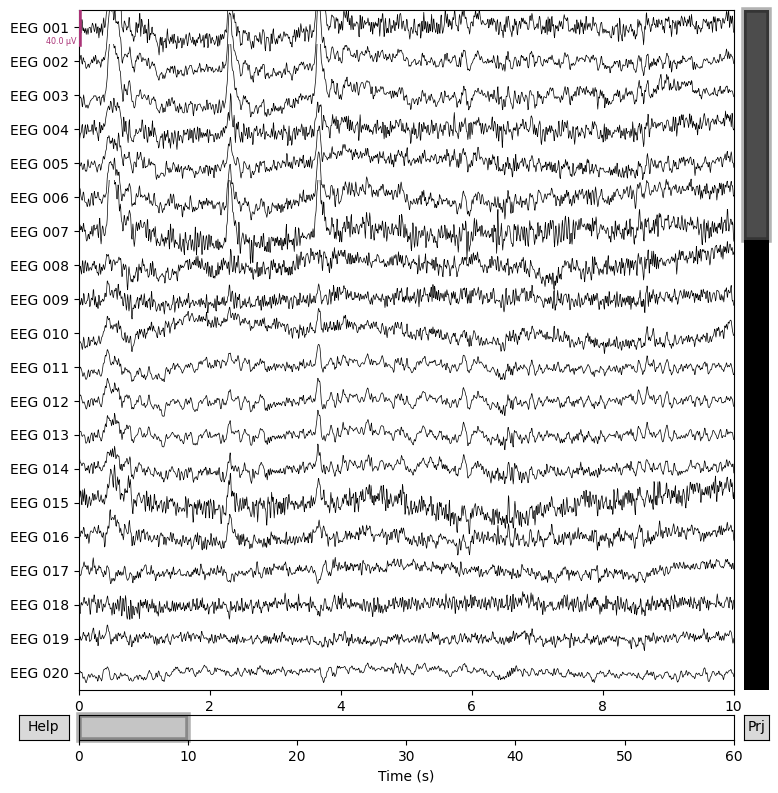

In [ ]:
import numpy as np
import mne
import pyxdf
from google.colab import files

# ขั้นตอนที่ 2: อัปโหลดไฟล์ XDF
uploaded = files.upload()

# เลือกไฟล์ XDF ที่อัปโหลด
xdf_file = list(uploaded.keys())[0]

# ขั้นตอนที่ 3: อ่านข้อมูลจากไฟล์ XDF
streams, header = pyxdf.load_xdf(xdf_file)

# ตรวจสอบ streams ในไฟล์ XDF
for stream in streams:
    print(f"Stream Name: {stream['info']['name'][0]}")
    print(f"Stream Type: {stream['info']['type'][0]}")
    print(f"Stream Shape: {stream['time_series'].shape}")
    print()

# หา stream ที่เป็น EEG
eeg_stream = None
for stream in streams:
    if 'EEG' in stream['info']['type'][0]:
        eeg_stream = stream
        break

if eeg_stream is None:
    print("ไม่พบข้อมูล EEG ในไฟล์ XDF")
else:
    # แปลงข้อมูล EEG เป็น array
    eeg_data = np.array(eeg_stream['time_series']).T  # ทำการ transpose เนื่องจากข้อมูลใน XDF จะมีรูปแบบ (samples, channels)

    # สร้างข้อมูลในรูปแบบ RawArray เพื่อใช้กับ MNE
    info = mne.create_info(ch_names=[f"EEG{i}" for i in range(eeg_data.shape[0])], sfreq=float(eeg_stream['info']['nominal_srate'][0]), ch_types='eeg')
    raw = mne.io.RawArray(eeg_data, info)

    # แสดงข้อมูลของ raw
    print(raw.info)

    raw.crop(0, 60) # keeps the first minute of data and discards the rest
raw.plot()
